В качестве домашнего задания вам предлагается поработать над предсказанием погоды. Файл с данными вы найдете в соответствующей директории. Вам будет доступен датасет weather.csv, ПЕРВЫЕ 75% (shuffle = False) которого нужно взять для обучения, последние 25% - для тестирования.

Требуется построить 4 модели которые будут предсказывать целевую переменную <b>RainTomorrow</b> с помощью:

   1. логистической регрессии [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
   
   2. метода ближайших соседей [sklearn.neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
 
   3. Байесовского классификатора [sklearn.naive_bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
   
   4. логистической регрессии реализованной самостоятельно

Затем следует сравнить результаты моделей (по качеству и времени выполнения) и сделать вывод о том, какая модель и с какими параметрами даёт лучшие результаты.

Не забывайте о том, что работа с признаками играет очень большую роль в построении хорошей модели.

Краткое описание данных:

    Date - Дата наблюдений
    Location - Название локации, в которой расположена метеорологическая станция
    MinTemp - Минимальная температура в градусах цельсия
    MaxTemp - Максимальная температура в градусах цельсия
    Rainfall - Количество осадков, зафиксированных за день в мм
    Evaporation - Так называемое "pan evaporation" класса А (мм) за 24 часа до 9 утра
    Sunshine - Число солнечных часов за день
    WindGustDir - направление самого сильного порыва ветра за последние 24 часа
    WindGustSpeed - скорость (км / ч) самого сильного порыва ветра за последние 24 часа
    WindDir9am - направление ветра в 9 утра

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import time
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from pandas_profiling import ProfileReport
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split

### Подготовка данных
__Анализ__

In [3]:
X = pd.read_csv('weather.csv')
X.describe()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,142193.000000,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000
mean,72884.900649,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235
std,42069.147355,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594
min,0.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000
25%,36235.000000,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000
50%,73311.000000,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000
75%,109247.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000
max,145458.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000


In [4]:
X.head(5)

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     142193 non-null  int64  
 1   Date           142193 non-null  object 
 2   Location       142193 non-null  object 
 3   MinTemp        141556 non-null  float64
 4   MaxTemp        141871 non-null  float64
 5   Rainfall       140787 non-null  float64
 6   Evaporation    81350 non-null   float64
 7   Sunshine       74377 non-null   float64
 8   WindGustDir    132863 non-null  object 
 9   WindGustSpeed  132923 non-null  float64
 10  WindDir9am     132180 non-null  object 
 11  WindDir3pm     138415 non-null  object 
 12  WindSpeed9am   140845 non-null  float64
 13  WindSpeed3pm   139563 non-null  float64
 14  Humidity9am    140419 non-null  float64
 15  Humidity3pm    138583 non-null  float64
 16  Pressure9am    128179 non-null  float64
 17  Pressure3pm    128212 non-nul

In [41]:
#profile = ProfileReport(X, title="Pandas Profiling Report")

In [42]:
#profile.to_file("weather_report.html")

In [43]:
#profile.to_notebook_iframe()

__Заполнение пропусков__

Набор данных характеризуется упорядоченностью по времени года и локации (город), поэтому большинство пропусков будет заполняться значенями, средними по локации: 

    MinTemp - среднее по локации
    MaxTemp - среднее по локации
    Rainfall - среднее по локации
    Evaporation - пустые строки заполняются 0 (так как парметр есть не для всех городов)
    Sunshine - пустые строки заполняются 0 (так как парметр есть не для всех городов)
    WindGustDir - пустые строки заполняются "NotGiven"
    WindGustSpeed - среднее по локации
    
    WindDir9am - пустые строки заполняются "Not given"
    WindDir3pm - пустые строки заполняются "Not given"
    WindSpeed9am - средним по локации
    WindSpeed3pm - средним по локации
    
    Humidity9am - среднее по локации
    Humidity3pm - среднее по локации
    Pressure9am - среднее по локации
    Pressure3pm - среднее по локации
    Cloud9am - пустые строки заполняются 0 (мало значений и они разнятся)	
    Cloud3pm - пустые строки заполняются 0 (мало значений и они разнятся)		
    Temp9am - среднее по локации
    Temp3pm - среднее по локации
    RainToday - пустые строки заполняются 0
    
    RainTomorrow - целевая переменная

In [6]:
columns = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed','WindSpeed9am','WindSpeed3pm',
           'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
for locat in X.Location.unique():
    mean  = X[X['Location'] == locat].mean()[columns]
    values = dict(mean)
    rows =  X.loc[X['Location'] == locat]
    rows.fillna(value = values,inplace = True)
    X.loc[X['Location'] == locat] = rows

In [7]:
#дозаполним оставшиеся пропуски
X.fillna(value = {
    "Evaporation": 0,
    "Sunshine": 0,
    "WindGustDir": "NotGiven",
    "WindDir9am": "NotGiven",
    "WindDir3pm": "NotGiven",
    "Cloud9am": 0,
    "Cloud3pm": 0,
    "RainToday": 0,
    "Pressure9am": 0, #X.Pressure9am.mean(), 
    "Pressure3pm": 0, #X.Pressure3pm.mean(), 
    "WindGustSpeed": 0 #X.WindGustSpeed.mean(), 
}, inplace=True)

__Преобразование и разбиаение__ 

Разбивается в пропорции 75% - train и 25% - test. Обучение модели и подбор гиперпараметров будет производиться только на train с ипользование CV

In [8]:
X.RainToday.replace({'No':0, 'Yes': 1}, inplace=True)
X.RainTomorrow.replace({'No':0, 'Yes': 1}, inplace=True)
y = X.RainTomorrow

Преобразуем дату и сотавим только месяц - так алгоритм сможет "привязаться" к времени года

In [9]:
X.Date = X.Date.apply(lambda x: x.split("-")[1])

Из-за отсутсвия перемешки при разбиении парметр "Location" можно удалить

In [10]:
X.drop(columns=['RainTomorrow','Unnamed: 0', 'Location'], inplace=True)


In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 21 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    142193 non-null  object 
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     142193 non-null  object 
 9   WindDir3pm     142193 non-null  object 
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-nul

Разобьем на тренироввочну и тестовую

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [13]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = list(X_train.dtypes[X_train.dtypes == np.number].index)

### 1. Логистическая регрессия

In [14]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

In [15]:
%%time
column_transformer = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('numeric', MinMaxScaler(), numeric)
])

pipeline_LR = Pipeline(steps=[
    ('cat_and_num', column_transformer),
    ('classify', LogisticRegressionCV())
])

model = pipeline_LR.fit(X_train, y_train)
y_pred = model.predict(X_test)

Wall time: 43.3 s


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91     27882
           1       0.77      0.41      0.53      7667

    accuracy                           0.85     35549
   macro avg       0.81      0.69      0.72     35549
weighted avg       0.84      0.85      0.83     35549



In [17]:
roc_auc_score(y_test, y_pred)

0.6871963080318912

### 2. метода ближайших соседей

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [19]:
%%time
pipline_KN = Pipeline(steps=[
    ('cat_and_num', column_transformer),
    ('classify', KNeighborsClassifier(n_neighbors=10))
])

#создадим модель 
model_knn = pipline_KN.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test) 

Wall time: 3min 30s


In [20]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     27882
           1       0.64      0.12      0.20      7667

    accuracy                           0.80     35549
   macro avg       0.72      0.55      0.54     35549
weighted avg       0.77      0.80      0.74     35549



In [21]:
#исследуем и найдем оптимальное количество соседей
parametrs = [
    {
        'classify': [KNeighborsClassifier()],
        'classify__n_neighbors': [5, 10, 20, 50, 100]
    }
]

grid_search = GridSearchCV(pipline_KN, param_grid=parametrs, cv=3, verbose=2)

In [ ]:
%%time
model = grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=5; total time= 2.3min
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=5; total time= 2.3min
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=5; total time= 2.3min
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=10; total time= 2.3min
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=10; total time= 2.3min
[CV] END classify=KNeighborsClassifier(), classify__n_neighbors=10; total time= 2.5min


In [89]:
y_pred_knn_opt = model.predict(X_test)

In [92]:
print(classification_report(y_test, y_pred_knn_opt))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88     27882
           1       0.70      0.09      0.16      7667

    accuracy                           0.80     35549
   macro avg       0.75      0.54      0.52     35549
weighted avg       0.78      0.80      0.73     35549



In [93]:
grid_search.best_params_

{'classify': KNeighborsClassifier(n_neighbors=20), 'classify__n_neighbors': 20}

### 3. Баесовский классификатор

In [115]:
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.base import TransformerMixin

In [116]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [117]:
pipline_nb = Pipeline(steps=[
    ('cat_and_num', column_transformer),
    ('to_dense', DenseTransformer()), 
    ('classify', CategoricalNB())
])

#исследуем и найдем оптимальную модель
parametrs_nb = [
    {
        'classify': [CategoricalNB()]
    },
    {
        'classify': [GaussianNB()]
    }
]

#создадим модель 
grid_nb = GridSearchCV(pipline_nb, param_grid=parametrs_nb, cv=3, verbose=2)

In [119]:
%%time
model_nb = grid_nb.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END ...........................classify=CategoricalNB(); total time=   0.5s
[CV] END ...........................classify=CategoricalNB(); total time=   0.5s
[CV] END ...........................classify=CategoricalNB(); total time=   0.5s
[CV] END ..............................classify=GaussianNB(); total time=   0.4s
[CV] END ..............................classify=GaussianNB(); total time=   0.4s
[CV] END ..............................classify=GaussianNB(); total time=   0.4s
Wall time: 3.65 s


In [120]:
y_pred_nb  = model_nb.predict(X_test)

In [121]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85     27882
           1       0.49      0.62      0.54      7667

    accuracy                           0.78     35549
   macro avg       0.69      0.72      0.70     35549
weighted avg       0.80      0.78      0.79     35549



### 4. Реализация логистической регрессии
__Логистическая регрессия__

$$p(y|x) = a(x, \theta) = \sigma(\langle x, \theta \rangle) = \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}$$

In [143]:
theta = np.array([1, 2, 3])

X =  np.array([[ 1,  1, 1],
               [-1, -2, 1],
               [-1, -2, 2],
               [-2, -2, -3]
              ])

y = np.array([1, 1, 0, 0])

In [123]:
def probability(theta, X):
    result = 1 / (1 + np.exp(- np.dot(theta, X.T) ))
    return result
prob = probability(theta, X)


assert type(prob) == np.ndarray, 'Возвращается неверный тип'
assert prob.shape == (X.shape[0],), 'Неверный размер массива'
assert (prob.round(3) == [0.998, 0.119, 0.731, 0.]).all(), 'Функция считается неверно'

Функция предсказания метки класса, получает на вход вероятности принадлежности к классу 1 и выдает метки классов $y \in \{0, 1\}$

In [124]:
def binary_class_prediction(theta, X, threshold =.5):
    prob =  probability(theta, X)
    result = prob >= threshold
    return result

y_pred = binary_class_prediction(theta, X)


assert type(y_pred) == np.ndarray, 'Возвращается неверный тип'
assert y_pred.shape == (X.shape[0],), 'Неверный размер массива'
assert min(y_pred) == 0, 'Функция считается неверно'
assert max(y_pred) == 1, 'Функция считается неверно'

In [125]:
y_pred, prob

(array([ True, False,  True, False]),
 array([9.97527377e-01, 1.19202922e-01, 7.31058579e-01, 3.05902227e-07]))

__Функционал качества логистической регрессии__

Запишем правдободовие выборки для меток класса $y \in \{+1, -1\}$ 

$$Likelihood(a, X^\ell) = \prod_{i = 1}^{\ell} a(x_i,\theta)^{[y_i = +1]} (1 - a(x_i, \theta))^{[y_i = -1]} → \operatorname*{max}_{\theta}$$ 

Прологарифмируем правдоподобие выборки и перейдем к задаче минимизации:

$$Q(a, X^\ell) =     -\sum_{i = 1}^{\ell} 
        [y_i = +1] \log a(x_i, \theta)
        +
        [y_i = -1] \log (1 - a(x_i, \theta)) \to \operatorname*{min}_{\theta}$$ 
        
Подставим $a(x, \theta)$ в функцинал качества:

$$ Q(a, X^\ell) = -\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{\exp(-\langle \theta, x_i \rangle)}{1 + \exp(-\langle \theta, x_i \rangle)}
\right)
=\\
=
-\sum_{i = 1}^{\ell} \left(
    [y_i = +1]
    \log \frac{1}{1 + \exp(-\langle \theta, x_i \rangle)}
    +
    [y_i = -1]
    \log \frac{1}{1 + \exp(\langle \theta, x_i \rangle)}
\right)
=\\
=
\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) $$
    

Итоговый оптимизируемый функционал качества (logloss), записанный для меток классов $y \in \{+1, -1\}$ и усредненный по выборке

$$Q(a, X^\ell) = \frac{1}{\ell}\sum_{i = 1}^{\ell}
    \log \left(
        1 + \exp(-y_i \langle \theta, x_i \rangle)
    \right) \to \operatorname*{min}_{\theta}$$

Реализуем его в функции logloss:

In [126]:
def logloss(theta, X, y): 
    y = np.where( y == 0 , -1, 1)
    result = np.sum( np.log(1 + np.e**(- y*np.dot(theta, X.T))) )/y.shape[0]
    return result

In [127]:
assert logloss(theta, X, y).round(3) == 0.861, 'Функция считается неверно'

__Алгоритм оптимизации функционала качества. Стохастический градиентный спуск__

<b>Вход: </b> Выборка $X^\ell$, темп обучения $h$

<b>Выход: </b> оптимальный вектор весов $\theta$

1.  Инициализировать веса $\theta$
2.  Инициализировать оценку функционала качества: $Q(a, X^\ell)$
3.  <b>Повторять</b>: 

    Выбрать случайным образом подвыборку объектов $X^{batch} =\{x_1, \dots,x_n \}$ из $X^{\ell}$
    
    Рассчитать градиент функционала качества: $\nabla Q(X^{batch}, \theta)$
    
    Обновить веса: $\theta := \theta - h\cdot \nabla Q(X^{batch}, \theta)$
       
    <b>Пока</b> значение $Q$ и/или веса $\theta$ не сойдутся   

Реализуем функцию рассчета градиента функционала качества

$$\frac{\partial Q(a, X^{batch}) }{\partial \theta_j}   = \frac{\partial \frac{1}{n}\sum_{i = 1}^{n}
    \log \left(
        1 + \exp(- y_i \langle \theta, x_i \rangle)
    \right)} {\partial \theta_j}  = \frac{1}{n}\sum_{i = 1}^{n}
     \frac {1}{
        1 + \exp(- y_i \langle \theta, x_i \rangle)} \cdot  \exp(- y_i \langle \theta, x_i \rangle) \cdot -y_i x_{ij}$$

Реализуйте рассчет градиента в матричном виде:

In [231]:
def gradient(theta, X, y):
    y = np.where(y == 0, -1, 1)
    exp = np.e**( - y*X.dot(theta) )
    result = np.sum( 1/(1 + exp ) * exp * (-y*X.T), axis=1)/y.shape[0]
    return result 

assert gradient(theta, X, y).shape == theta.shape, 'Неверный размер массива'

Функция обучения уже реализована

In [232]:
def fit(X, y, batch_size=10, h=0.05,  iters=100, plot=True):

    # получаем размерности матрицы
    size, dim = X.shape

    # случайная начальная инициализация
    theta = np.random.uniform(size=dim)
    
    errors = []
    
    theta_history = theta
    colors = [plt.get_cmap('gist_rainbow')(i) for i in np.linspace(0,1,dim)]
    
    # plt 
    if plot:
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(212)
        fig.suptitle('Gradient descent')
        
        
    for _ in range(iters):  
        
        # берём случайный набор элементов
        batch = np.random.choice(size, batch_size, replace=False)
        X_batch = X[batch]
        y_batch = y[batch]

        # считаем производные
        grad = gradient(theta, X_batch, y_batch)
        
        assert type(grad) == np.ndarray, 'неверный тип'
        assert len(grad.shape) == 1, 'Необходимо вернуть одномерный вектор'
        assert grad.shape[0] == len(theta), 'длина вектора должна быть равной количеству весов'
        
        
        # Обновляем веса
        
        theta -= grad * h
        
        theta_history = np.vstack((theta_history, theta))
        
        # error
        loss = logloss(theta, X, y)
        errors.append(loss)
        
        if plot:
            ax1.clear()            
            ax1.scatter(range(dim), theta, label='Gradient solution')
            ax1.legend(loc="upper left")
            ax1.set_title('theta')
            ax1.set_ylabel(r'$\bar \beta$')
            ax1.set_xlabel('weight ID')
            
            
            ax2.plot(range(_+1), errors, 'g-')
            ax2.set_title('logloss')
            ax2.set_xlabel('itarations')
            
            ax3.plot(theta_history)
            ax3.set_title('update theta')
            ax3.set_ylabel('value')
            ax3.set_xlabel('itarations')
            time.sleep(0.05)
            fig.canvas.draw()   
            
    return theta

In [130]:
X, y = make_classification(n_samples=2000)
X.shape

(2000, 20)

In [131]:
optimal_theta = fit(X, y, plot=False)

In [132]:
y_pred = binary_class_prediction(optimal_theta, X)

In [133]:
print (classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       998
           1       0.81      0.83      0.82      1002

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



Обучим модель на данных

In [253]:
X_train_sc = column_transformer.fit_transform(X_train).toarray()

In [254]:
X_test_sc = column_transformer.fit_transform(X_test).toarray()

<IPython.core.display.Javascript object>


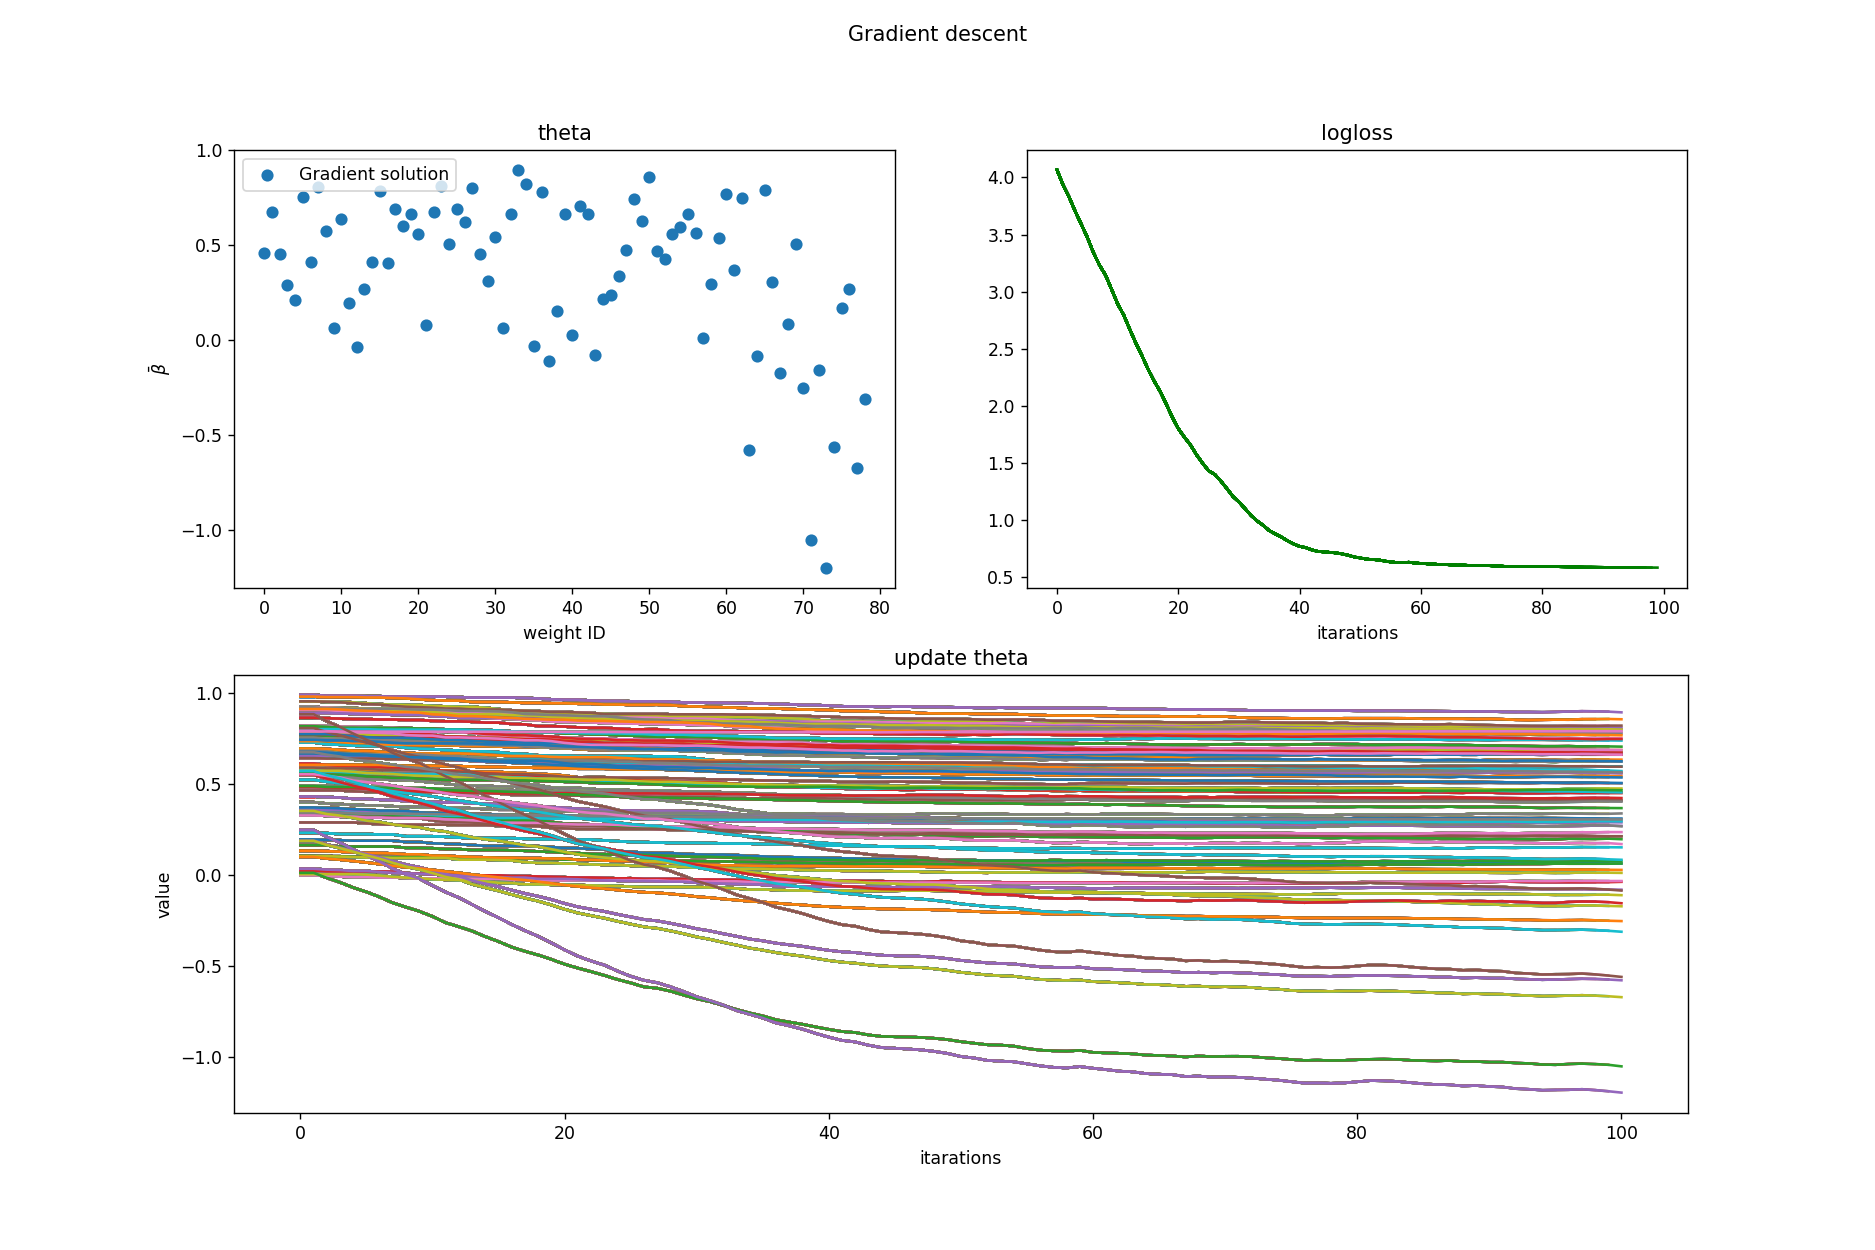

In [255]:
theta_opt = fit(X_train_sc, y_train, batch_size=20)

In [256]:
y_pred_sc = binary_class_prediction(theta_opt, X_test_sc)

In [257]:
print(classification_report(y_test, y_pred_sc))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     27882
           1       0.19      0.08      0.11      7667

    accuracy                           0.73     35549
   macro avg       0.49      0.49      0.48     35549
weighted avg       0.66      0.73      0.68     35549



### Вывод